# Pulsar Star Detection

Hi! Thanks for checking this notebook. 

Can we predict a pulsar star in the universe? 

Let's use the HTRU2 dataset and ML techniques to find out!

In [1]:
import dython.nominal as dm
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option("display.max_rows", 100)

In [3]:
data = pd.read_csv("../input/pulsar_stars.csv")
data.columns = ['mean_ip', 'sd_ip', 'ek_ip', 'skw_ip', 'mean_dm', 'sd_dm', 'ek_dm', 'skw_dm', 'pulsar']
data.head()

,mean_ip,sd_ip,ek_ip,skw_ip,mean_dm,sd_dm,ek_dm,skw_dm,pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# Exploratory Analysis

In [4]:
data.describe()

,mean_ip,sd_ip,ek_ip,skw_ip,mean_dm,sd_dm,ek_dm,skw_dm,pulsar
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


It seems there are outliers for a good share of the features.

Let's check how balanced are the two classes we want to predict:

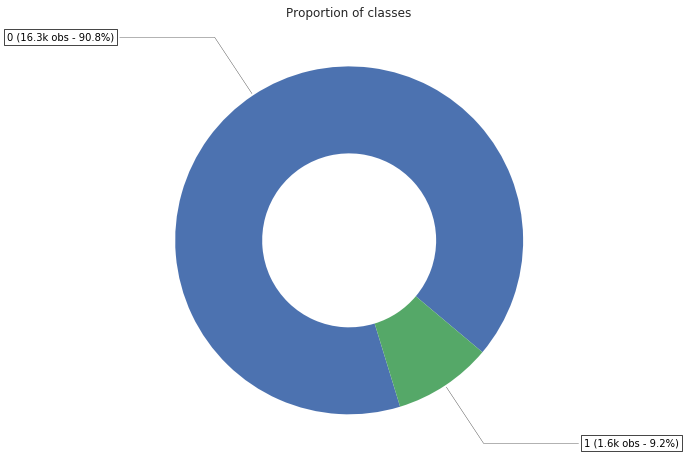

In [5]:
def donut_chart(data):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

    recipe = [str(i) for i in list(data.value_counts().index)]

    info = data.value_counts()

    def pcts(val_list):
        pct = []
        for val in val_list:
            pct.append(" ({:.1f}k obs - {:.1f}%)".format(val/1000, 100*val/np.sum(val_list)))
        return pct

    recipe2 = pcts(info)

    wedges, texts = ax.pie(info, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        kw["color"] = 'k'
        ax.annotate(recipe[i]+recipe2[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Proportion of classes")
    plt.show()
    
donut_chart(data['pulsar'])

Classes are heavily unbalanced, which means we will need a stratified splitting strategy latter on for the classification algorithms.

Next, let's check the PDF and CDF for each feature:

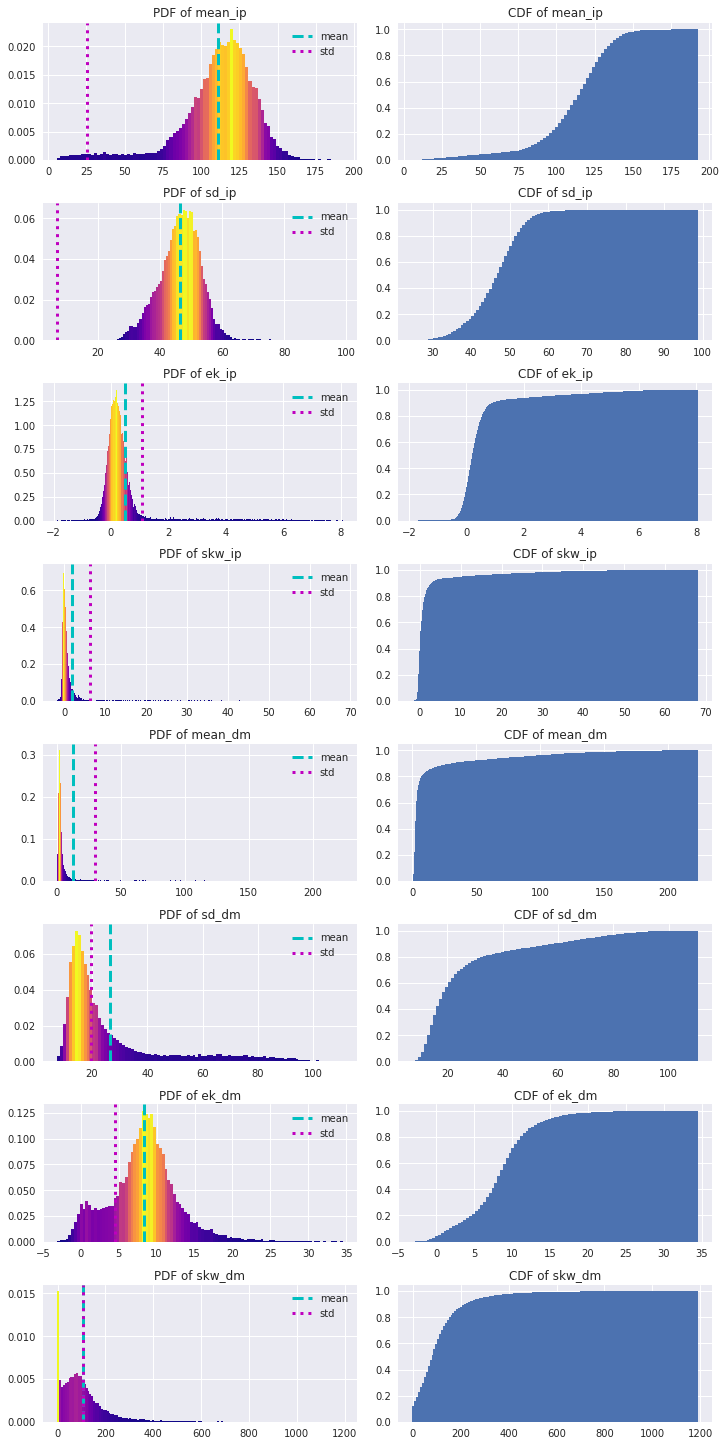

In [6]:
from matplotlib import colors

preds = [col for col in data.columns if col != "pulsar"]
num_preds = len(preds)
fig, axes = plt.subplots(num_preds, 2, figsize=(10,20))

for i, j in itertools.zip_longest(preds, range(num_preds)):
    N, bins, patches = axes[j, 0].hist(data[i], bins="auto", density=True)
    axes[j, 0].set_title(f"PDF of {i}")
    
    axes[j, 0].axvline(data[i].mean(), color = "c", linestyle="dashed", label="mean", linewidth=3)
    axes[j, 0].axvline(data[i].std(), color = "m", linestyle="dotted", label="std", linewidth=3)
    axes[j, 0].legend(("mean", "std"), loc="best")
    
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.plasma(norm(thisfrac))
        thispatch.set_facecolor(color)
    
    axes[j, 1].hist(data[i], bins="auto", cumulative=True, density=True)
    axes[j, 1].set_title(f"CDF of {i}")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Indeed, we can see that the distributions present outliers. In cases such as for skw_ip or mean_dm the effect of outliers is very extreme. 

We need to determine what to do with these observations.

Let's check the distributions, comparing the two classes for every feature:

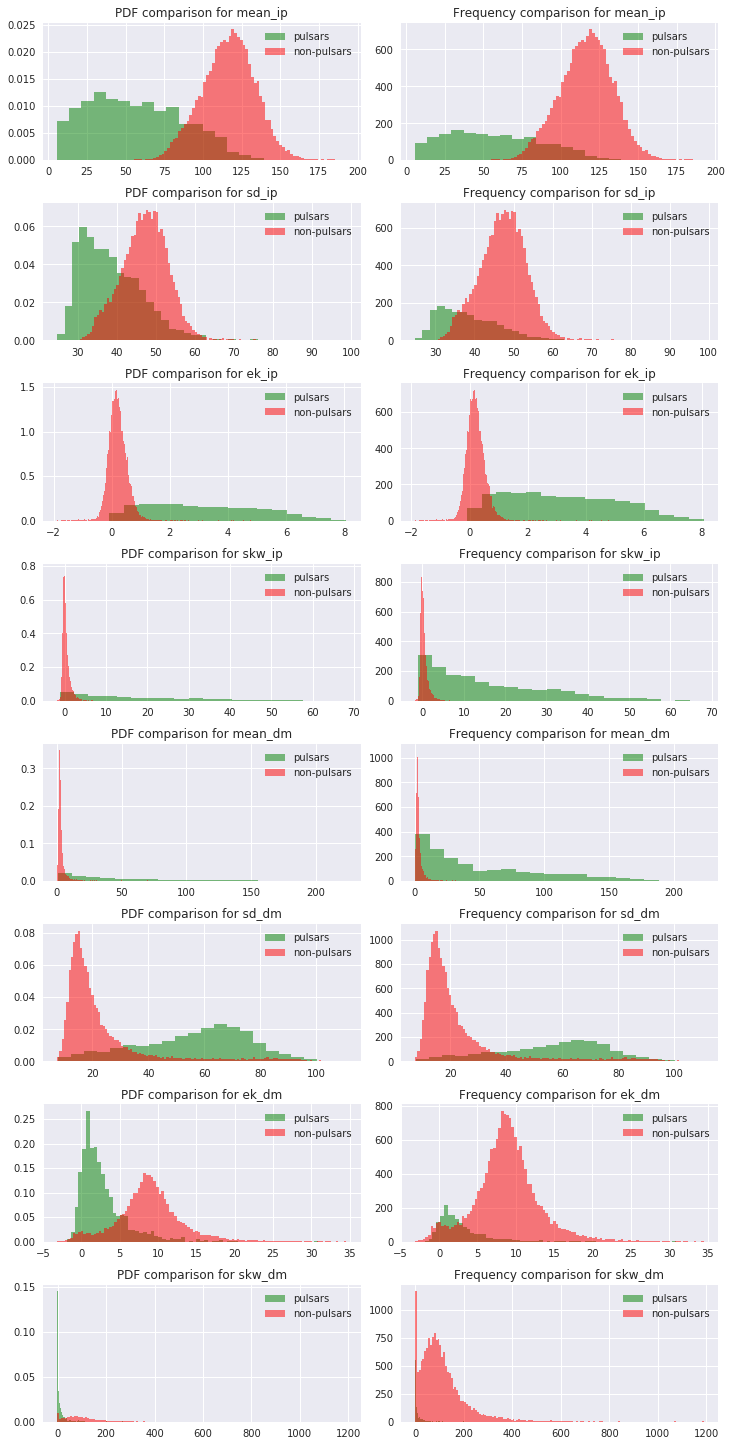

In [7]:
pulsars = data[data['pulsar'] == 1].drop('pulsar', axis=1)
non_pul = data[data['pulsar'] == 0].drop('pulsar', axis=1)

fig, axes = plt.subplots(num_preds, 2, figsize=(10,20))

for i, j in itertools.zip_longest(preds, range(num_preds)):
    axes[j, 0].hist(pulsars[i], bins="auto", label="pulsars", color = "g", alpha=0.5, density=True)
    axes[j, 0].hist(non_pul[i], bins="auto", label="non-pulsars", color = "r", alpha=0.5, density=True)
    axes[j, 0].set_title(f'PDF comparison for {i}')
    axes[j, 0].legend(loc="best")
    
    axes[j, 1].hist(pulsars[i], bins="auto", label="pulsars", color = "g", alpha=0.5)
    axes[j, 1].hist(non_pul[i], bins="auto", label="non-pulsars", color = "r", alpha=0.5)
    axes[j, 1].set_title(f'Frequency comparison for {i}')
    axes[j, 1].legend(loc="best")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

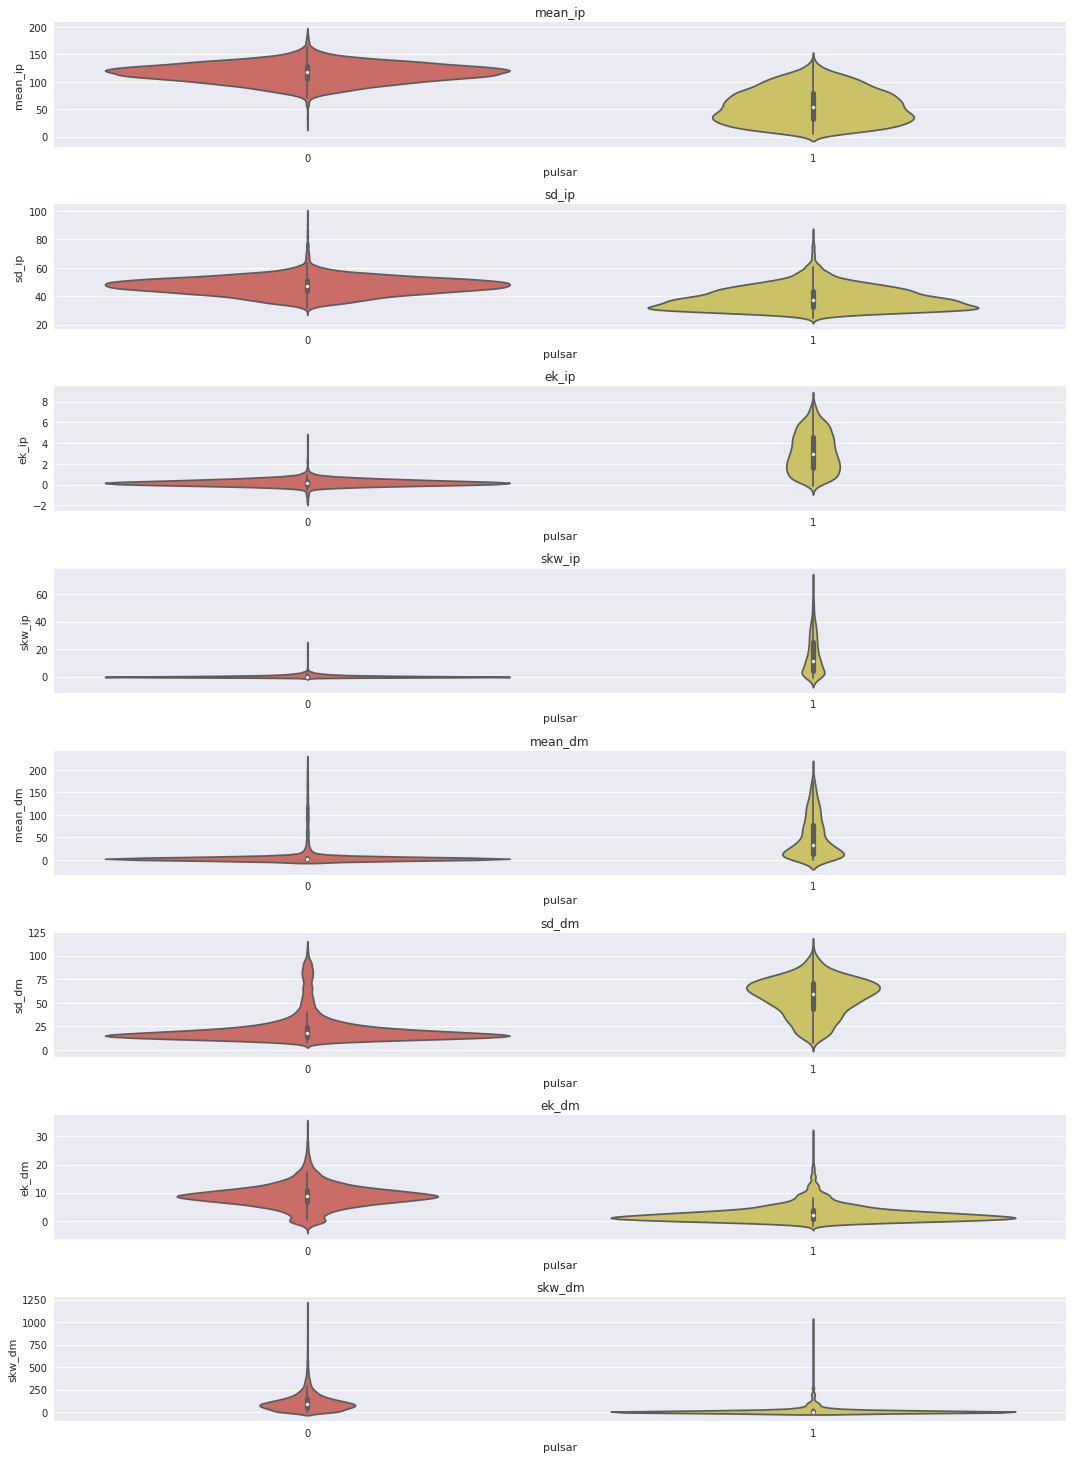

In [8]:
plt.figure(figsize=(15,25))

for i in range(num_preds):
    plt.subplot(10,1,i+1)
    sns.violinplot(x=data['pulsar'],y=data.iloc[:, i],
                   palette=sns.color_palette("hls", 7),alpha=.5)
    plt.title(data.columns[i])
    
plt.tight_layout()
plt.show()

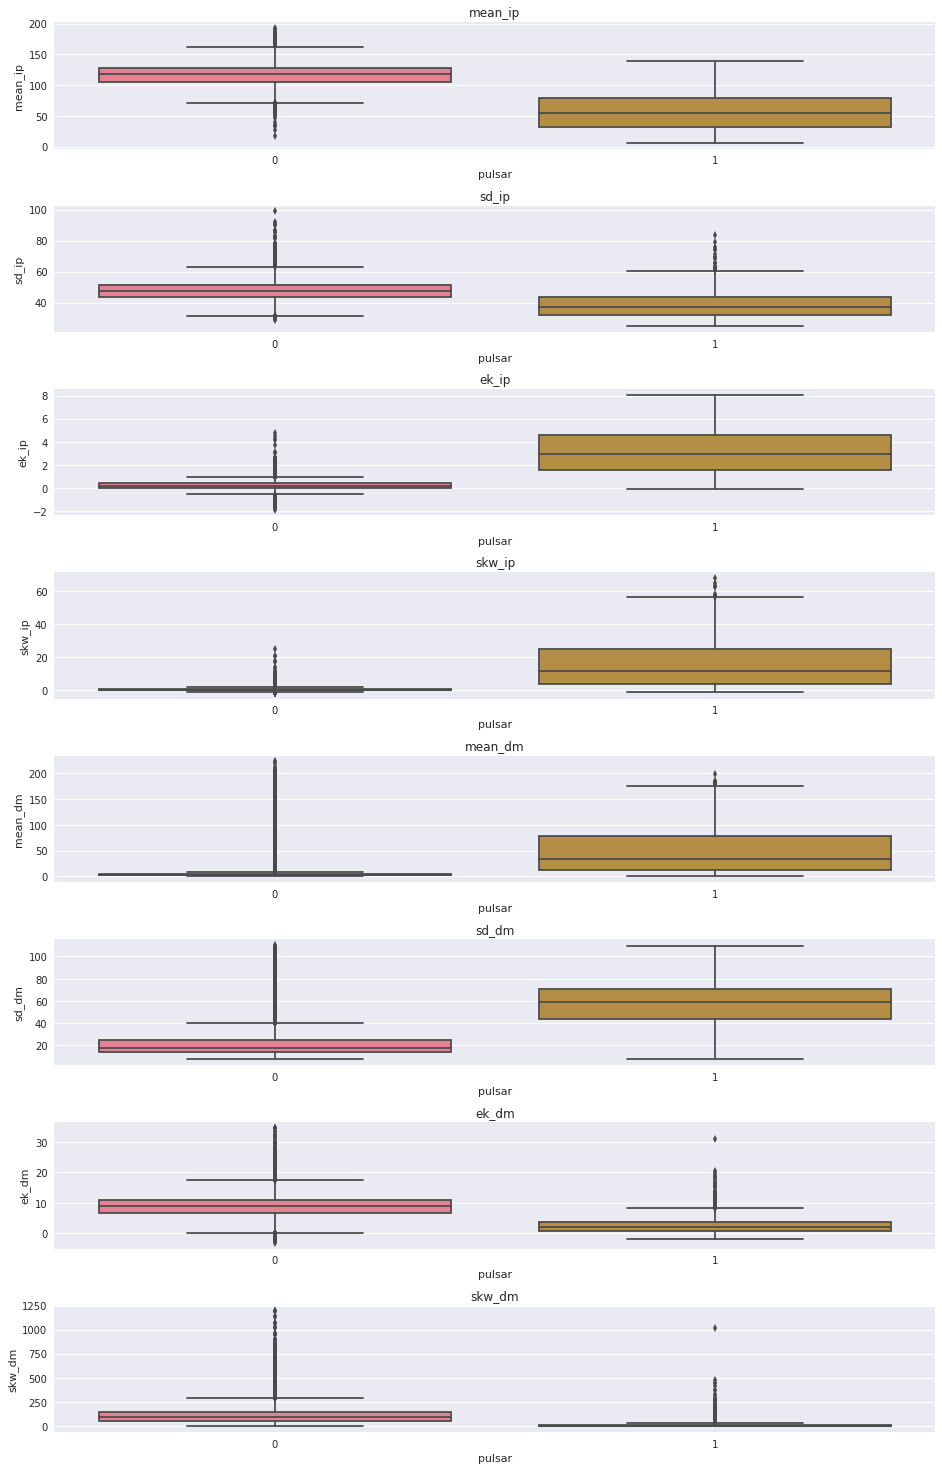

In [9]:
plt.figure(figsize=(13,25))

for i in range(num_preds):
    plt.subplot(10,1,i+1)
    sns.boxplot(data['pulsar'],y=data.iloc[:, i], 
                palette=sns.color_palette("husl", 7), color="w")
    plt.title(data.columns[i])
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

We can see that for all features, the two classes overlap in some degree. 

Of course, some variables will provide better info for the classification since they do a better job at separating the two classes. This is the case for: mean_ip, ek_ip and sd_dm.

Also, the outliers may play an important role in the classification.

Let's check the correlation between all pair of variables (including the response): 

/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


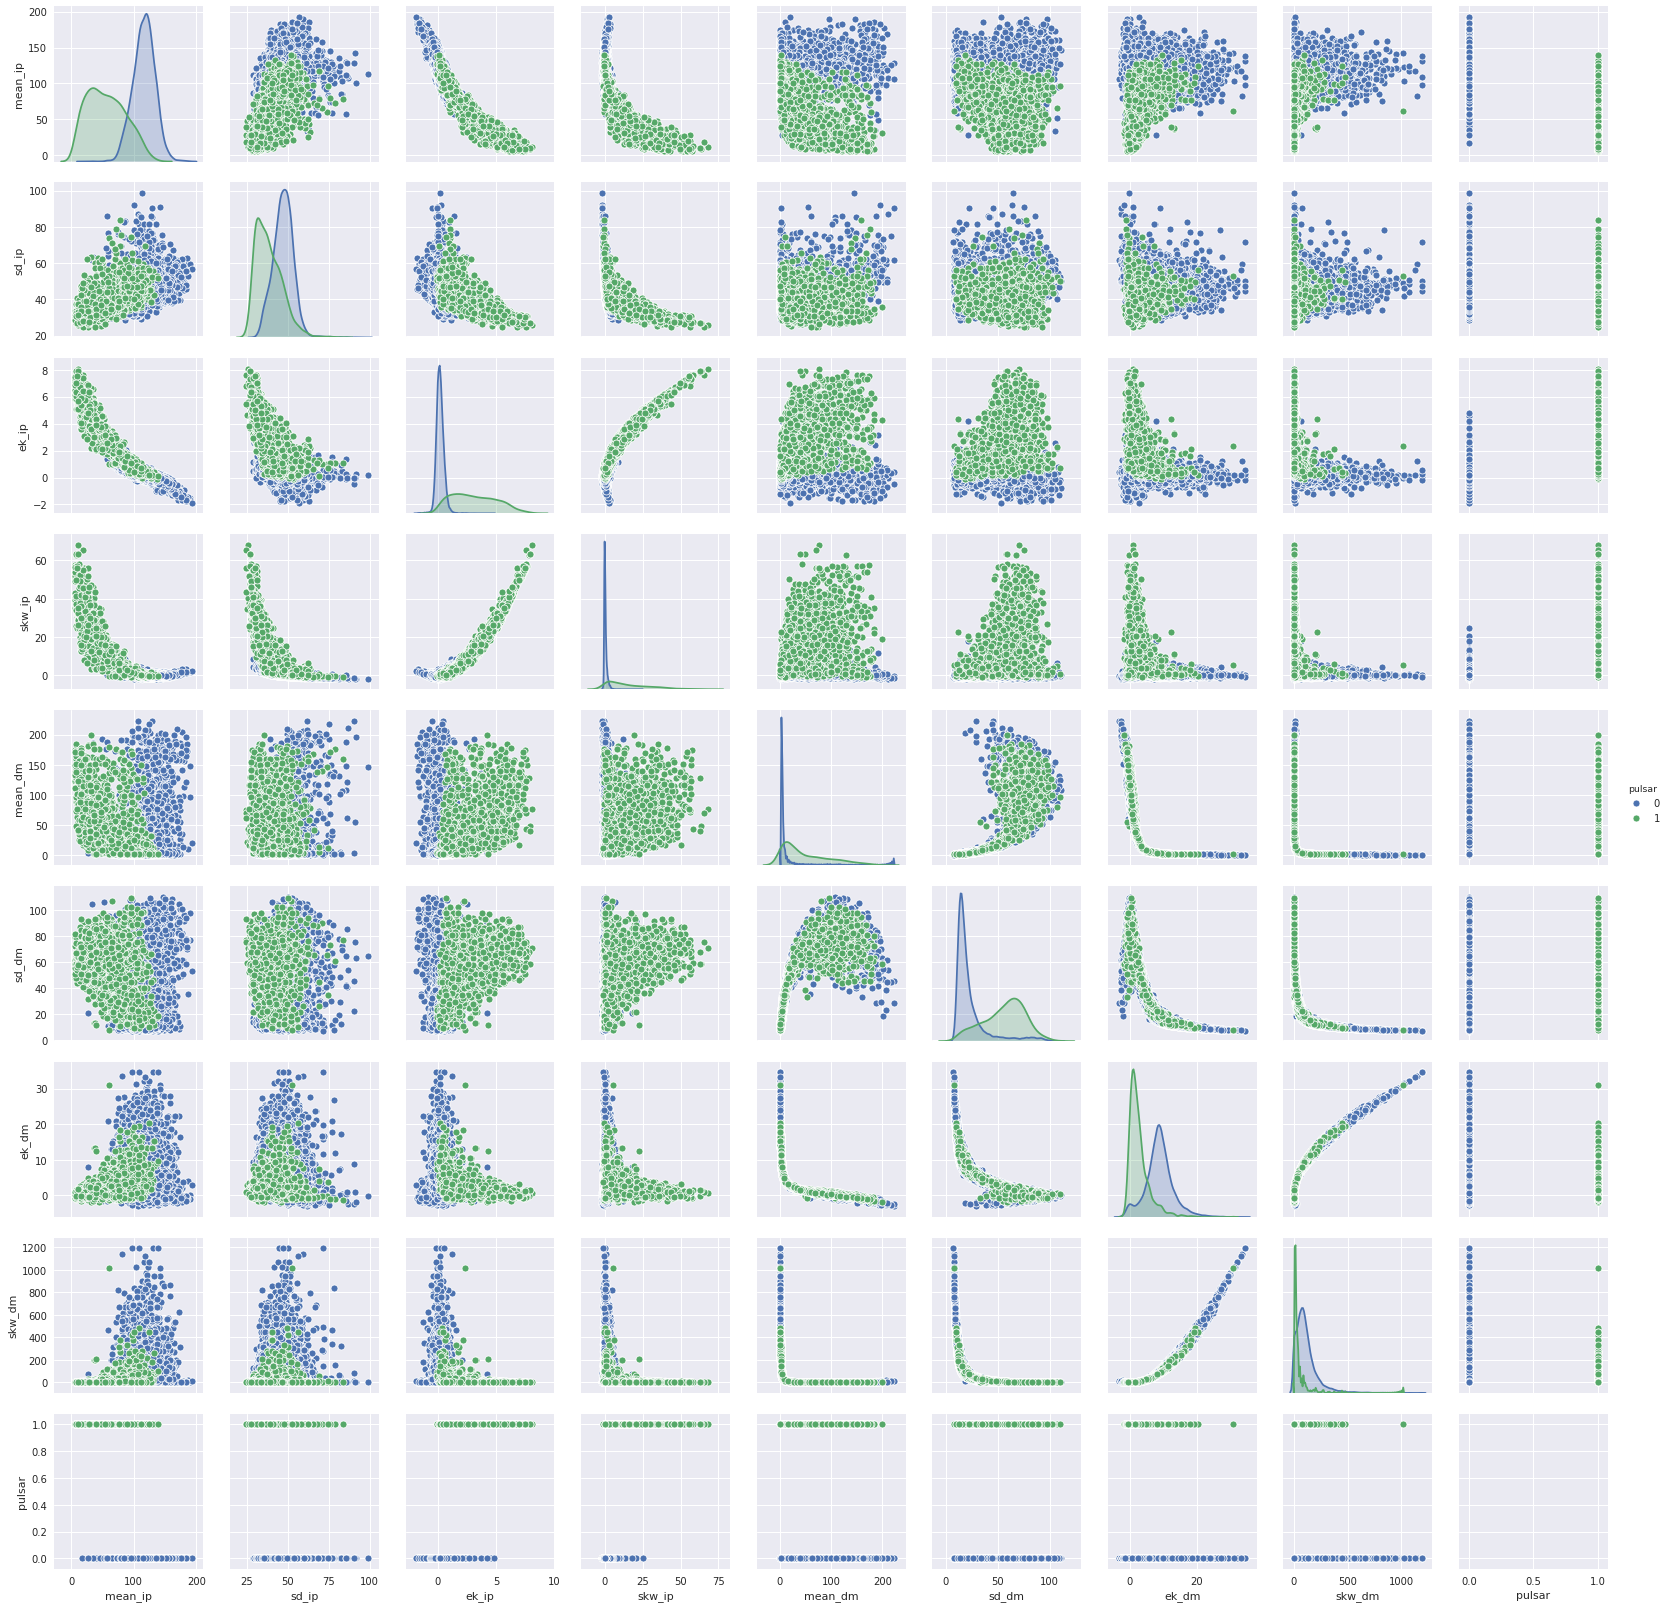

In [10]:
g = sns.pairplot(data,hue="pulsar")
plt.show()

Some variables are very closely correlated with others, because of this, regularization should be considered during the defition of the classifiers. Also, dimension reduction techniques such as PCA might come in handy.

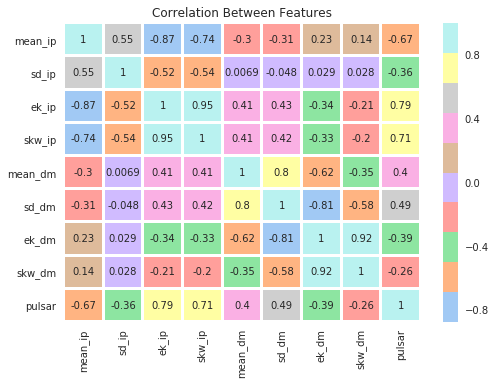

In [11]:
correlation = data.corr()
ax = sns.heatmap(correlation, annot=True, cmap=sns.color_palette("pastel"),
                 linewidth=2,edgecolor="k")
plt.title("Correlation Between Features")
plt.show()

To end the exploratory analysis, let's create a barplot with the correlation ratio for each feature with respect to the response variable. 

This is a metric that tries to capture the "correlation" between continuous and categorical variables.

The bigger the correlation ratio, the more info of a given class we can get from a given feature.

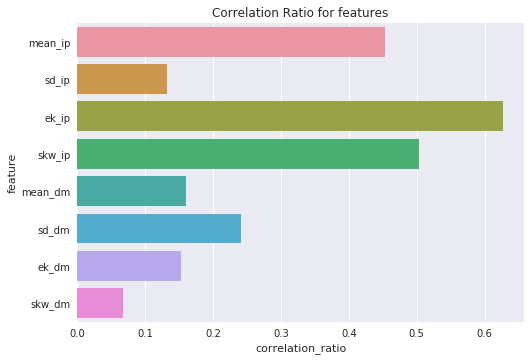

In [12]:
corr_ratios = [dm.correlation_ratio(data['pulsar'], data[pred]) for pred in preds]
df_cr = pd.DataFrame({'feature': preds, 'correlation_ratio':corr_ratios})

ax = sns.barplot(x="correlation_ratio", y="feature", data=df_cr)
ax.set_title("Correlation Ratio for features")
plt.show()

# Outlier Analysis

Now we'll focus our attention in the outliers since they seem to be predominant across the dataset. We want to know what to do with them, should we drop or keep them?

First let's define a function that returns a tuple containing the interquantile range, the list of "left" outliers (values much smaller than the others in the distribution) and the list of "right" outliers (values much greater than the others) for a given pandas series:

In [13]:
def get_outliers(feature):
    data_out = data[feature]
    q1 = data_out.quantile(0.25)
    q3 = data_out.quantile(0.75)
    iqr = q3 - q1

    out_l = data_out[data_out < (q1 - 1.5*iqr)].index
    out_r = data_out[data_out > (q3 + 1.5*iqr)].index
    
    return(iqr, out_l, out_r)

Using the previous function, let's print the quantity and proportion of left and right outliers for each feature across the two classes:

In [14]:
def print_outlier_group():
    for i in preds:
        print(f'Predictor: {i}\n')

        iqr, out_l, out_r = get_outliers(i)

        full_count = pd.DataFrame()

        lower_count = data.iloc[out_l].groupby('pulsar').size().to_frame('lower_count')
        upper_count = data.iloc[out_r].groupby('pulsar').size().to_frame('upper_count')

        if not lower_count.empty:
            lower_count['lower_ratio'] = lower_count/lower_count.sum()
        else:
            lower_count['lower_ratio'] = np.nan
        if not upper_count.empty:
            upper_count['upper_ratio'] = upper_count/upper_count.sum()
        else:
            upper_count['upper_ratio'] = np.nan

        full_count = pd.concat([lower_count, upper_count], axis=1)
        print(full_count)
        print('\n======\n')

print_outlier_group()

Predictor: mean_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0                29     0.029683         53.0          1.0
1               948     0.970317          NaN          NaN


Predictor: sd_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0                 2     0.015625          123      0.91791
1               126     0.984375           11      0.08209


Predictor: ek_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0             113.0          1.0          126     0.084963
1               NaN          NaN         1357     0.915037


Predictor: skw_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0               NaN          NaN          589     0.309837
1               NaN          NaN  

In most of the cases there seems to be a correlation between the proportion of either left or right outliers and the class we are trying to predict. 

This seems to indicate that the outliers contain information about the class to which a celestial object belongs.

To dive even deeper into this, let's create a dataframe that for every observation contains the info of it being a left or right outlier for every feature, as well as the total count of features in which it is an outlier and the class it belongs to.

      mean_ip sd_ip ek_ip skw_ip mean_dm sd_dm ek_dm skw_dm  count  pulsar
8326        L  None     R      R       R     R     L   None      6       1
14620       L     L     R      R       R     R  None   None      6       1
11492       L     L     R      R       R     R  None   None      6       1
11493       L     L     R      R       R     R  None   None      6       1
1493        L     L     R      R       R     R  None   None      6       1
5700        L     L     R      R       R     R  None   None      6       1
5665        L     L     R      R       R     R  None   None      6       1
5661        L     L     R      R       R     R  None   None      6       1
5654        L     L     R      R       R     R  None   None      6       1
11527       L     L     R      R       R     R  None   None      6       1
11542       L     L     R      R       R     R  None   None      6       1
11554       L     L     R      R       R     R  None   None      6       1
5545        L     L     R

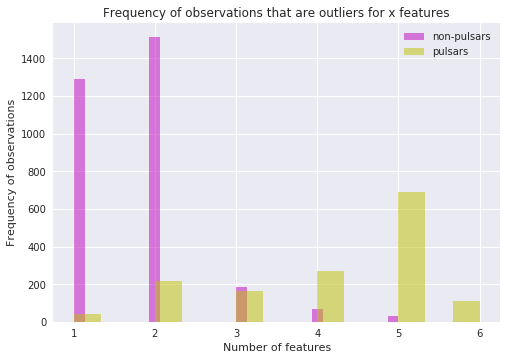

In [15]:
def update_outlier_dict(ou, out_list, label, i):
    for elem in list(out_list):
        if ou.get(elem) is None:
            ou.update({elem: dict.fromkeys(preds, None)})
        ou.get(elem).update({i: label})
        
def print_outliers_df():
    ou = {}
    for i in preds:
        iqr, out_l, out_r = get_outliers(i)
        
        update_outlier_dict(ou, out_l, "L", i)
        update_outlier_dict(ou, out_r, "R", i)

    df = pd.DataFrame.from_dict(ou, orient='index')
    df['count'] = df.count(axis=1)
    df['pulsar'] = data['pulsar'].iloc[df.index]
    #print(df.groupby('pulsar').size().to_frame('count_r'))
    print(df.sort_values('count', ascending=False))
    #print(df.groupby('count').size())
    plt.hist(df[df['pulsar']==0]['count'], bins='auto', color = "m", alpha=0.5)
    plt.hist(df[df['pulsar']==1]['count'], bins='auto', color = "y", alpha=0.5)
    plt.legend(labels=['non-pulsars', 'pulsars'])
    plt.title("Frequency of observations that are outliers for x features")
    plt.xlabel("Number of features")
    plt.ylabel("Frequency of observations")
    plt.show()

print_outliers_df()

We can see that in a general sense, the probability of an observation being a pulsar star increases with the number of features it is an outlier of. 

This relationship can be more complex than this but there is a correlation between being an outlier and belonging to a specific class. In this case outliers are not merely noise, but provide useful info for the classification procedure and **must not be removed**

# Dimension Reduction - PCA

Let's use PCA to reduce the dimension of this problem. Before doing this the data should be scaled so PCA doesn't interpret one feature as having more variance due to its scale.

Since we decided to leave outliers untouched a standard scaler would perfom badly. A robust scaler is used instead:

In [16]:
from sklearn.preprocessing import RobustScaler

float_data = data[preds].astype(np.float64)
robust_trans = RobustScaler().fit(float_data)
robust_data = pd.DataFrame(robust_trans.transform(data[preds]), 
                     columns= ['mean_ip', 'sd_ip', 'ec_ip', 
                               'sw_ip', 'mean_dm', 'sd_dm', 
                               'ec_dm', 'sw_dm'])

robust_data.describe()

,mean_ip,sd_ip,ec_ip,sw_ip,mean_dm,sd_dm,ec_dm,sw_dm
count,17898.000000,1.789800e+04,1.789800e+04,1.789800e+04,17898.000000,1.789800e+04,1.789800e+04,17898.000000
mean,-0.152857,-4.602048e-02,5.706002e-01,1.407768e+00,2.770987,5.621705e-01,-2.640654e-02,0.208849
std,0.980757,7.913778e-01,2.384525e+00,5.525048e+00,8.322905,1.391672e+00,9.156018e-01,1.020755
min,-4.177419,-2.564469e+00,-4.704446e+00,-1.783122e+00,-0.731008,-7.927284e-01,-2.351497e+00,-0.814974
25%,-0.540920,-5.286647e-01,-4.395563e-01,-3.469167e-01,-0.248155,-2.876170e-01,-5.388670e-01,-0.460993
50%,0.000000,-4.108516e-16,3.110030e-17,-1.243275e-17,0.000000,1.269669e-16,1.804722e-16,0.000000
75%,0.459080,4.713353e-01,5.604437e-01,6.530833e-01,0.751845,7.123830e-01,4.611330e-01,0.539007
max,2.964456,5.994024e+00,1.758361e+01,6.082557e+01,62.292899,6.588692e+00,5.304597e+00,10.617621


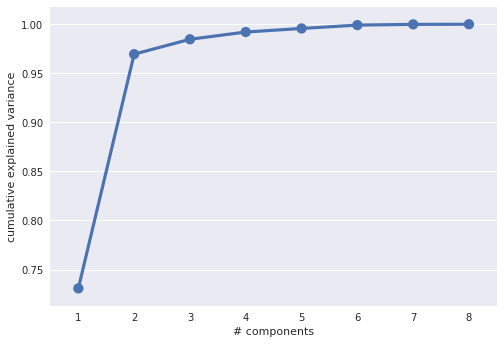

In [17]:
from sklearn.decomposition import PCA

pca_all = PCA()
pca_all.fit(robust_data)

cum_var = (np.cumsum(pca_all.explained_variance_ratio_))
n_comp = [i for i in range(1, pca_all.n_components_ + 1)]

ax = sns.pointplot(x=n_comp, y=cum_var)
ax.set(xlabel='# components', ylabel='cumulative explained variance')
plt.show()

With few components we can explain most of the variance of the data. This indicates that PCA is gonna be really useful for the classification of this dataset.

Let's visualize the 2 and 3 first principal components:

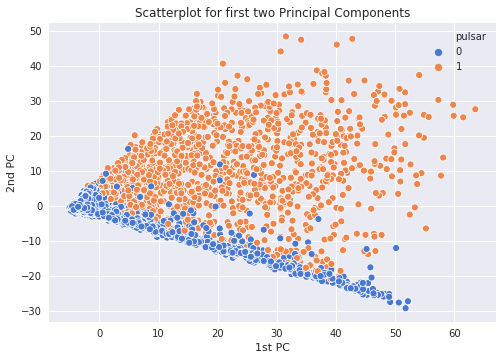

In [18]:
pca_2 = PCA(2)
pca_2.fit(robust_data)
data_2pc = pca_2.transform(robust_data)

ax = sns.scatterplot(x=data_2pc[:,0], 
                     y=data_2pc[:,1], 
                     hue=data['pulsar'],
                     palette=sns.color_palette("muted", n_colors=2))

ax.set(xlabel='1st PC', ylabel='2nd PC', title='Scatterplot for first two Principal Components')
plt.show()

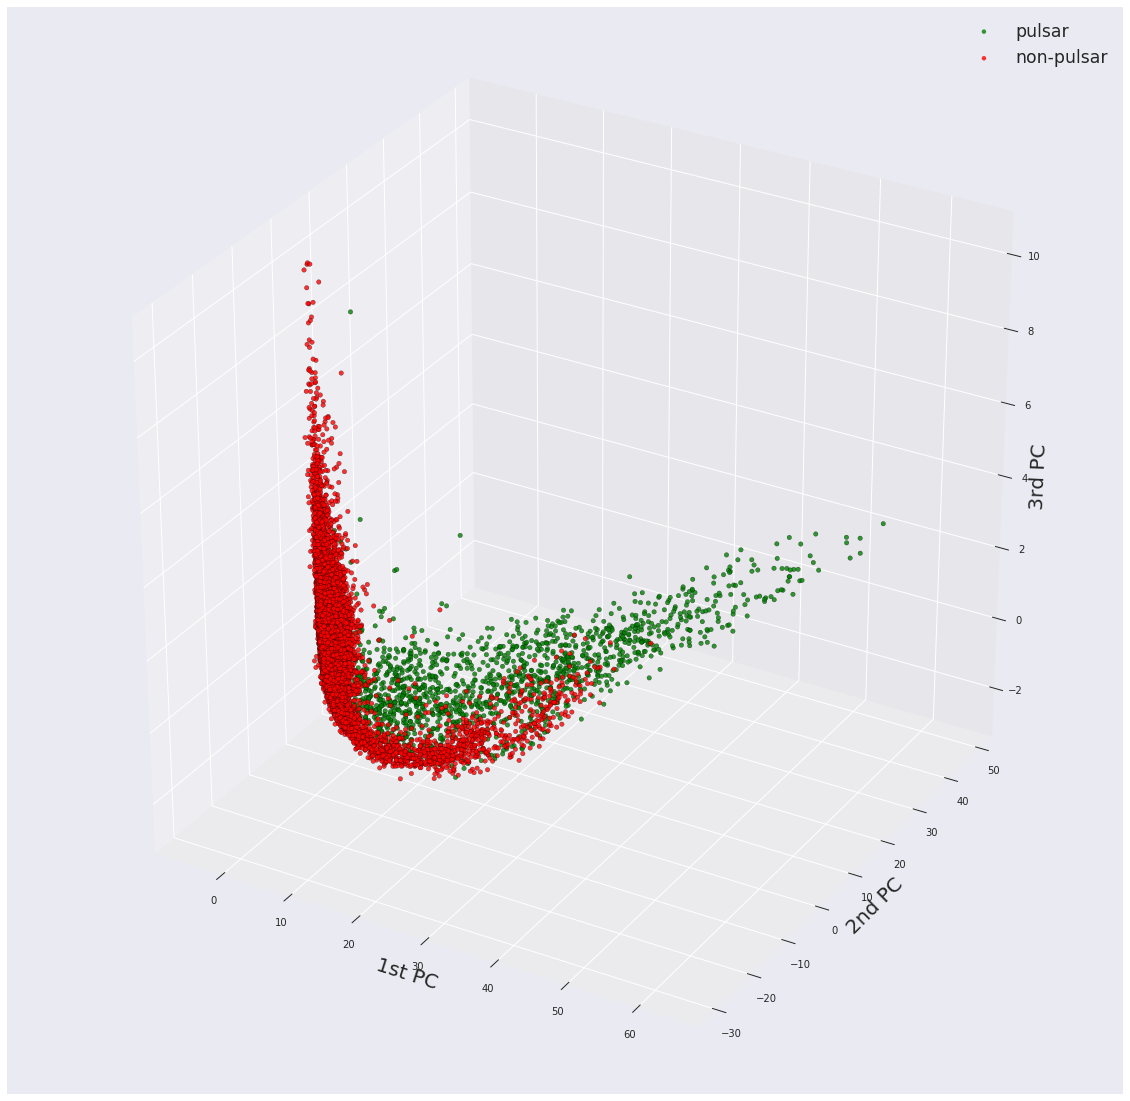

In [19]:
from mpl_toolkits.mplot3d import Axes3D

pca_3 = PCA(3)
pca_3.fit(robust_data)
data_3pc = pca_3.transform(robust_data)

pulsar_index = list(pulsars.index)
non_pulsar_index = list(non_pul.index)

x = data_3pc[:,0]
y = data_3pc[:,1]
z = data_3pc[:,2]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.take(x, pulsar_index), 
           np.take(y, pulsar_index), 
           np.take(z, pulsar_index),
           edgecolors='none', color='g',
           alpha=0.8, label='pulsar')


ax.scatter(np.take(x, non_pulsar_index), 
           np.take(y, non_pulsar_index), 
           np.take(z, non_pulsar_index),
           edgecolors='none', color='r',
           alpha=0.8, label='non-pulsar')

ax.set_xlabel("1st PC", fontsize=20)
ax.set_ylabel("2nd PC", fontsize=20)
ax.set_zlabel("3rd PC", fontsize=20)
ax.legend(fontsize="xx-large")
plt.show()

It is possible to see that there exists and hyperplane that will do a good job at correctly classifying a pulsar star. 

Probably not perfectly but we'll see if good enough.

# Classifiers

For comparing the different classifiers we need to define a proper metric. 

Since this problem has a strong class imbalance we'll be using balanced accuracy as the main metric, which is the average of recall for both classes. 

As a secondary metric we'll use recall as I assume that False Negatives are worst than False Positives because pulsars are very rare and failing to correctly detect them (while misclassifying non-pulsars as pulsars) is worst than the other way around. 

**However, I don't have any background in astrophysics and this is merely an assumption**

Let's begin by separating the response variable from the predictors:

In [20]:
X = data[preds]
y = data[['pulsar']]

With the help of cross validation, let's define a function that will help us compare the ML algorithms:

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

def eval_model(model):
    pipe = make_pipeline(RobustScaler(), model)
    cv_results = cross_validate(pipe, X, y.values.ravel(), cv=3, scoring=('balanced_accuracy',
                                                                           'recall'))
    
    print("=== Mean Test Results for {} ===".format(type(model).__name__))
    print("BALANCED ACCURACY: {:.3f}".format(cv_results.get('test_balanced_accuracy').mean()))
    print("RECALL: {:.3f}".format(cv_results.get('test_recall').mean()))


One of the algorithms used is a KNN, which needs some hyperparameter tuning. Let's do that:

In [22]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), 
                                                    test_size=0.1, random_state=0,
                                                    stratify=y)

tuned_parameters = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rob_scal = RobustScaler()
rob_scal.fit(X_train)
X_train = rob_scal.transform(X_train)

clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=3, scoring='balanced_accuracy')
clf.fit(X_train, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.913 (+/-0.020) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.914 (+/-0.019) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.911 (+/-0.017) for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.913 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.905 (+/-0.011) for {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
0.906 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
0.900 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}
0.903 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}
0.911 (+/-0.014) for {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
0.911 (+/-0.013) for {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
0.912 (+/-0.012) for {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
0.912 (+/-0.013) for {'metric': 'manhattan', 'n_neighbor

The reason why we did a train test split is to have a separate split of the data in which we can test the selected hyperparameters. If all of the data was used, we would have leaked info and that should be avoided.

Seems that the best configuration is {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}. 

However all scores are quite similar, which indicates the KNN classifier is insensitive to tuning for this particular problem.

Let's check for overfitting:

In [23]:
from sklearn.metrics import balanced_accuracy_score

knn_tuning = KNeighborsClassifier(3, weights='distance', metric='euclidean')
knn_tuning.fit(X_train, y_train)
X_test = rob_scal.transform(X_test)
knn_tuning_preds = knn_tuning.predict(X_test)

print(balanced_accuracy_score(y_test, knn_tuning_preds))

0.9307480574805749


Now we compare the different classifiers:

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
 
gnb = GaussianNB()
logit = LogisticRegression(solver='liblinear', class_weight='balanced')
knn = KNeighborsClassifier(3, weights='distance', metric='euclidean')
xgb = XGBClassifier()

classifiers = [gnb, logit, knn, xgb]

for classifier in classifiers:
    eval_model(classifier)

=== Mean Test Results for GaussianNB ===
BALANCED ACCURACY: 0.900
RECALL: 0.846
=== Mean Test Results for LogisticRegression ===
BALANCED ACCURACY: 0.943
RECALL: 0.913
=== Mean Test Results for KNeighborsClassifier ===
BALANCED ACCURACY: 0.910
RECALL: 0.830
=== Mean Test Results for XGBClassifier ===
BALANCED ACCURACY: 0.917
RECALL: 0.841


Logistic regression is the clear winner for this problem, presenting the max score for the two metrics. 

Now let's use PCA (with 3 components, as it explains most of the variance) as an intermediate transform to see if prediction can be improved by removing noise from the data:

In [26]:
def eval_model_pca(model):
    pipe = make_pipeline(RobustScaler(), PCA(3), model)
    cv_results = cross_validate(pipe, X, y.values.ravel(), cv=3, scoring=('balanced_accuracy',
                                                                           'recall'))
    
    print("=== Mean Test Results for {} ===".format(type(model).__name__))
    print("BALANCED ACCURACY: {:.3f}".format(cv_results.get('test_balanced_accuracy').mean()))
    print("RECALL: {:.3f}".format(cv_results.get('test_recall').mean()))


In [28]:
classifiers = [gnb, logit, knn, xgb]

for classifier in classifiers:
    eval_model_pca(classifier)

=== Mean Test Results for GaussianNB ===
BALANCED ACCURACY: 0.785
RECALL: 0.611
=== Mean Test Results for LogisticRegression ===
BALANCED ACCURACY: 0.916
RECALL: 0.873
=== Mean Test Results for KNeighborsClassifier ===
BALANCED ACCURACY: 0.882
RECALL: 0.776
=== Mean Test Results for XGBClassifier ===
BALANCED ACCURACY: 0.876
RECALL: 0.757


PCA doesn't improve prediction. 

However, the results are similar while successfully reducing the dimension of the problem.

We didn't achieve perfect pulsar classification or perfect recall but gained a glimpse of the performance of different ML algorithms for this dataset. 

The task of classyfing pulsar stars is a difficult one and other techniques such as Neural Networks could improve our classification procedure, maybe in the future I will add them to this notebook. Also a more selective treatment or removal of outliers might help, but for the time being I'm satisfied with the visualization and analysis performed.

That's it! Thanks for reading!